### Convolution, Sigma Threshold, Trials Factor - Caleb Wilkins 10/18/2021

This notebook gives an extensive walkthrough of methods of analysis one can use the convolution operator for when dealing with data distributed in a variety of ways (continuous and discrete). Further, it delves into how to calculate a sigma threshold, and describes the importance of doing so. Finally, it explains the effect of the trials factor on the sigma threshold.

In [1]:
# imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats, signal
plt.rcParams["figure.figsize"] = (15,10)

The convolution operation can be used to calculate the probability of a sum or average. In this notebook, we are going to imagine that we are looking for gamma-ray sources (like scientists do with the Fermi telescope) in order to get practice doing this type of statistical analysis. In telescopes like Fermi, there is a background of cosmic-rays (electrons and protons, mostly) that provide a discrete noise term across the sky that precisely follows a Poisson distribution. To detect a gamma-ray source, we need to ask what the probability is that the cosmic-ray background would have given you a measurement as signal-like or more than the signal that you received. We will work through this step by step, so it is okay if the language of astronomy is unfamiliar as you read through this for the first time. 

To set up the problem, assume in 1 day the average cosmic-ray background is some number X; and the average number of gamma-rays emitted by your hypothetical source is some number Y (larger than X).

##### First, we show the probability distribution of the background:

We choose the average number of cosmic background rays seen per day to be 3.7, and the average number of gamma rays per day to be 7.

In [2]:
# As stated above, let X be our average cosmic-ray background number
X = 3.7

# And let Y be the average number of gamma rays emitted by our potential source
Y = 7

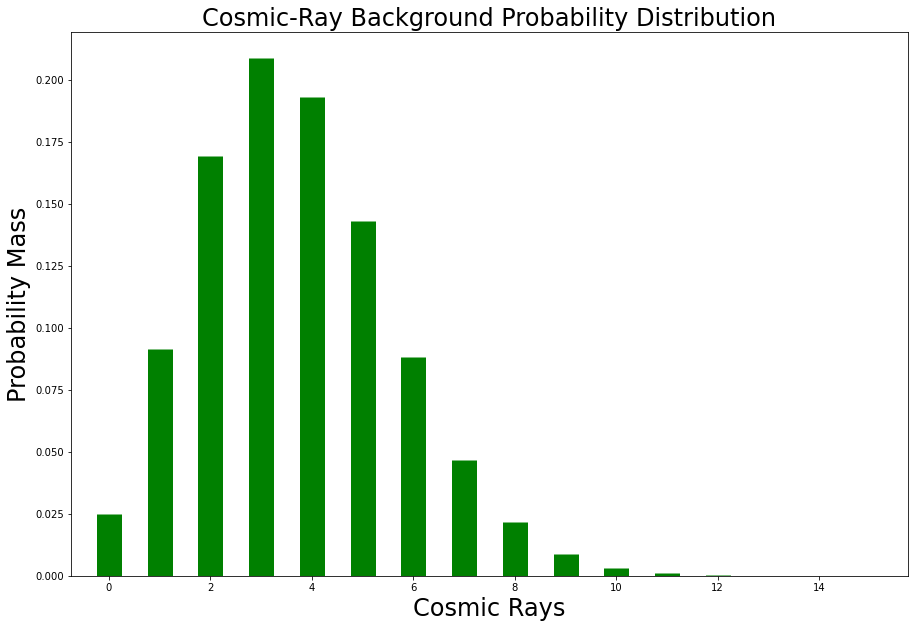

In [3]:
# The scipy package allows us to model our cosmic-ray background easily
# since we know it is Poisson distributed

cosmicray_dist = stats.poisson(X)

# For non-continuous distributions like the Poisson, we need to use the probability mass
# function rather than the probability density function to get the result we want
x = np.arange(0, 16)
poisson_pmf = cosmicray_dist.pmf(x)

# Plotting to visually analyze the distribution 
plt.xlabel("Cosmic Rays", fontsize=24)
plt.ylabel("Probability Mass", fontsize=24)
plt.title("Cosmic-Ray Background Probability Distribution", fontsize=24)
plt.vlines(x, 0, poisson_pmf, linewidth=25, color="g")
plt.ylim(0, None);

Since it is a Poisson distribution, we must use the probability mass function rather than the probability density function.

Now, let us show that after multiple days, the *summed* probability distribution is still a Poisson distribution. We will show this by convolving the distribution with itself over each additional day until we get to 5 days (an arbitrary choice).

In [4]:
# The purpose of the following function is to plot consecutive convolutions of 
# the probability distributions we are interested in

# The main arguments functions takes are simply a given probability mass (which 
# we again use scipy to obtain) and an integer, n, which will be the number of 
# plots it will generate 

def plot_sum(pmf, n, *args, **kwargs):
    new_pmf = pmf
    for i in range(n):
        new_pmf = np.convolve(new_pmf, pmf)
    plt.vlines(range(len(new_pmf)), 0, new_pmf, *args, **kwargs)
    plt.xlim(0, None)
    plt.ylim(0, None)

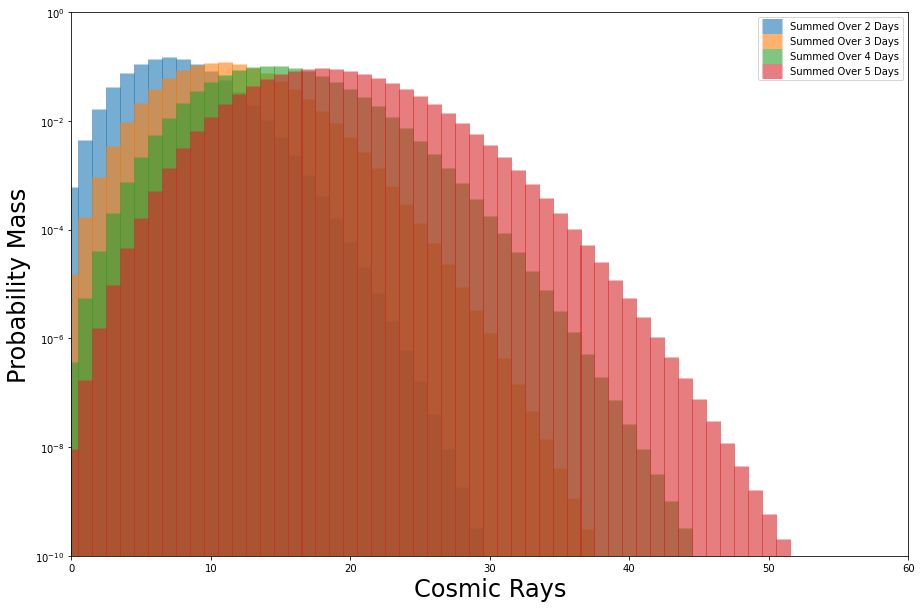

In [5]:
# We now use the above function to visualize the summing of probability distributions
# over the course of 5 consecutive days

for i in range(1, 5):
    plot_sum(cosmicray_dist.pmf(x), i, linewidth=15, color=f"C{i - 1}", alpha=0.6)
plt.xlabel("Cosmic Rays", fontsize=24)
plt.ylabel("Probability Mass", fontsize=24)
plt.legend([f'Summed Over {i + 1} Days' for i in range(1, 5)])
plt.yscale('log')
plt.xlim(0, 60)
plt.ylim(1e-10, 1);

We see that the sum over 5 days is still Poisson distributed, which is an expected result because it is a discrete distribution and thus summing over 5 days would essentially just add 5 discrete variables together, but would still leave the original shape of the distribution (the Poisson "tail" we see on the right of the graph). Mathematically, convolving the distribution 5 times would still result in a Poisson distribution, however with a new mean different than the one we chose.

##### Now, let's explore how the probability distribution evolves as we average over the days.

In [6]:
# This next function takes the same arguments as the previous one we used in the last section,
# but this time, however, its purpose is to plot the average of consecutively convolved
# probability distributions

def plot_avg(pmf, n, *args, **kwargs):
    new_pmf = pmf
    for i in range(n):
        new_pmf = np.convolve(new_pmf, pmf)
    plt.vlines(np.arange(len(new_pmf)) / (n + 1), 0, new_pmf, *args, **kwargs)
    plt.xlim(0, None)
    plt.ylim(0, None)

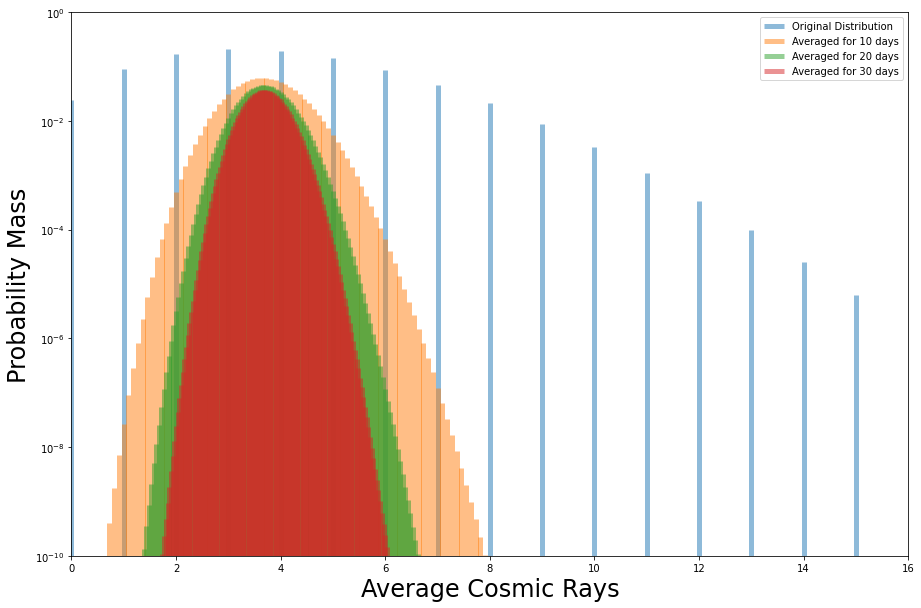

In [7]:
days = [0, 10, 20, 30]
for i in days:
    plot_avg(poisson_pmf, i, linewidth=5, color=f"C{i // 10}", alpha=0.5)
plt.xlabel("Average Cosmic Rays", fontsize=24)
plt.ylabel("Probability Mass", fontsize=24)
plt.legend(['Original Distribution', *[f"Averaged for {n} days" for n in days[1:]]])
plt.yscale('log')
plt.xlim(0, 16)
plt.ylim(1e-10, 1);

We see now that when we average a discrete distribution, it converges around its mean and appears more and more Gaussian. We will check if that pattern will continue further if we average over even more days.

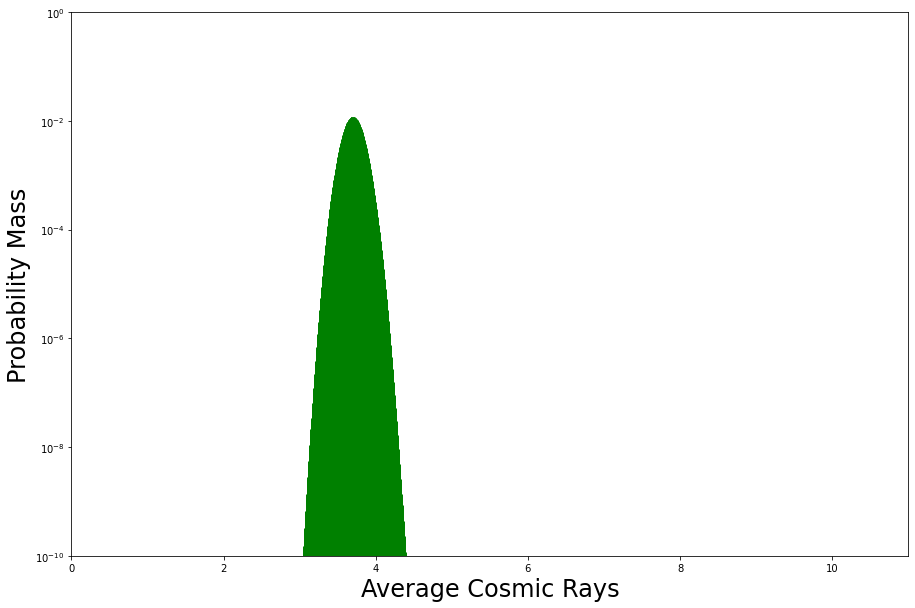

In [8]:
# Using 300 days is a large enough choice to see the result we desire, 
# yet arbitrary other than that

large_days = 300 
plot_avg(poisson_pmf, large_days, linewidth=1, color='g')
plt.xlabel("Average Cosmic Rays", fontsize=24)
plt.ylabel("Probability Mass", fontsize=24)
plt.yscale('log')
plt.xlim(0, 11)
plt.ylim(1e-10, 1);

Over more days our observation is proved even more, which makes sense due to the central limit theorem, which says that repeated convolution of a discrete distribution will eventually look more Gaussian than discrete. 

#### Continuing our investigation:
We will pick some number of days, N, and assume we observe Y * N gamma rays from your source. Let's calculate the 'sigma' of this observation, and verify if it is significant.
Assuming we wait 10 days, which means we assume to see (10 * 7) = 70 gamma rays based on our chosen Y. The probability that we saw 70 or more cosmic rays in 10 days from the background is the integral of the PMF summed for 10 days, from 70 to infinity. It is simpler, however, to use the survival function, 1 minus the cumulative distribution function.

In [9]:
prob = stats.poisson(37).sf(70 - 1)
print(prob)

8.711014760710385e-07


In [10]:
stats.norm.ppf(1 - prob)
print(f'The sigma value associated with the distribution summed over 10 days is {stats.norm.ppf(1 - prob):.2f}.')

The sigma value associated with the distribution summed over 10 days is 4.78.


##### Now, let's say a skewed continuous distribtuion, like the Rayleigh distribution, will now describe the background over some observing interval. Will this change the results we saw with the Poisson distributed case?

First we should visualize the distribution, then show how the distribution changes as we average over more observing intervals:

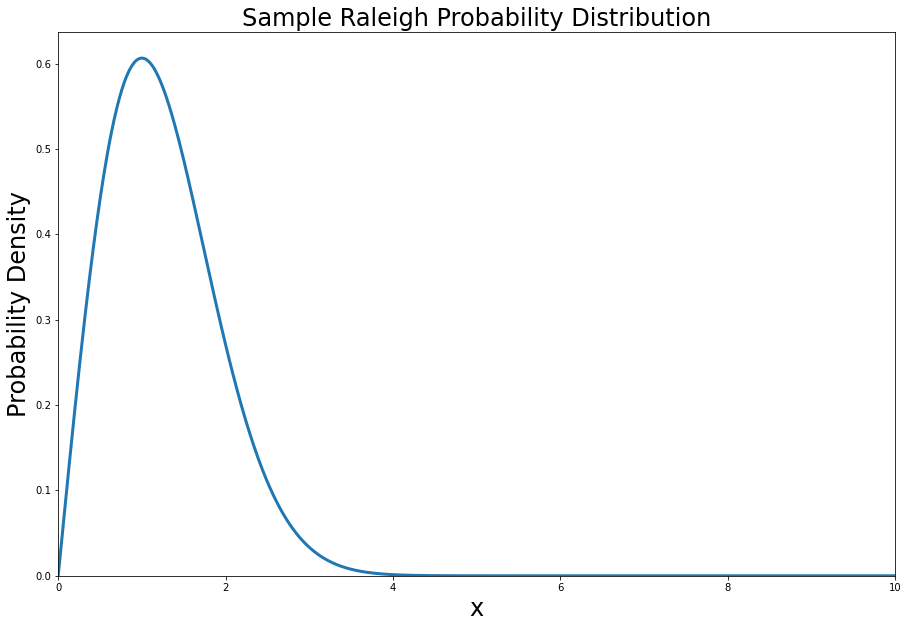

In [11]:
# We can again use scipy to generate a sample distribution for analysis

rayleigh_dist = stats.rayleigh(scale=1)
x = np.linspace(0, 10, 1000)
plt.xlabel("x", fontsize=24)
plt.ylabel("Probability Density", fontsize=24)
plt.title("Sample Raleigh Probability Distribution", fontsize=24)
plt.plot(x, rayleigh_dist.pdf(x), linewidth=3)
plt.xlim(0, 10)
plt.ylim(0, None);

We average over multiple intervals by convolving, just as we did for the Poisson case.

In [12]:
# This function operates the same way as our prior functions did,
# however some adjustments have been made to accomodate the Raleigh distribution,
# namely the necessary inclusion of the specified range of the x-axis

def plot_avg_rayleigh(x, pdf, n, *args, **kwargs):
    new_pdf = pdf
    for i in range(n):
        new_pdf = np.convolve(new_pdf, pdf)
    plt.plot(np.linspace(x[0], x[-1], len(new_pdf)), new_pdf, *args, **kwargs)
    plt.xlim(x[0], x[-1])

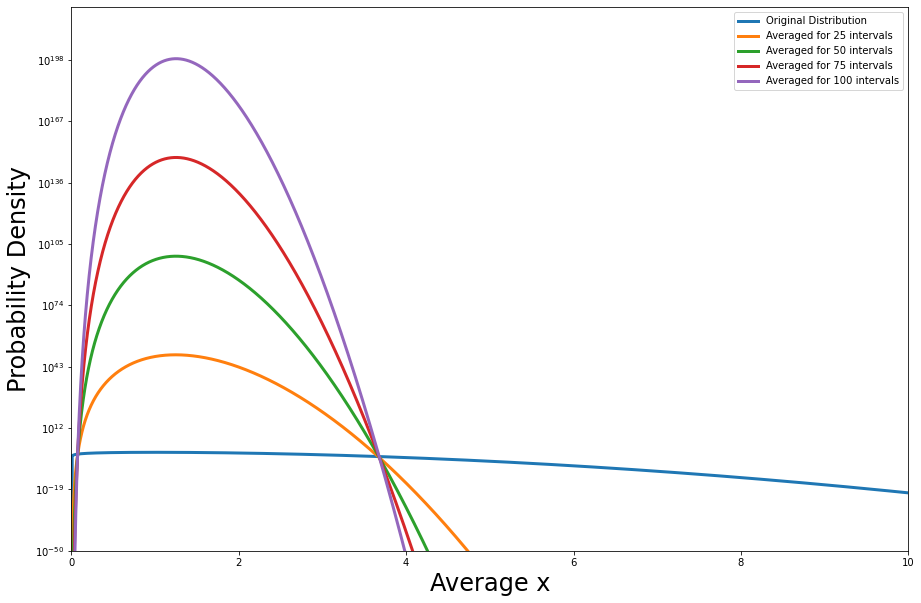

In [13]:
rayleigh_pdf = rayleigh_dist.pdf(x)
nums = [0, 25, 50, 75, 100]
for i in nums:
    plot_avg_rayleigh(x, rayleigh_pdf, i, linewidth=3)
plt.xlabel("Average x", fontsize=24)
plt.ylabel("Probability Density", fontsize=24)
plt.yscale('log')
plt.ylim(1e-50, None);
plt.legend(['Original Distribution', *[f"Averaged for {n} intervals" for n in nums[1:]]]);

With this type of distribution, even after averaging over 100 intervals, the distribution still has a visible "tail" that is convincingly non-Gaussian. Thus, we try an even higher number of intervals to see if we can achieve something that looks more Gaussian.

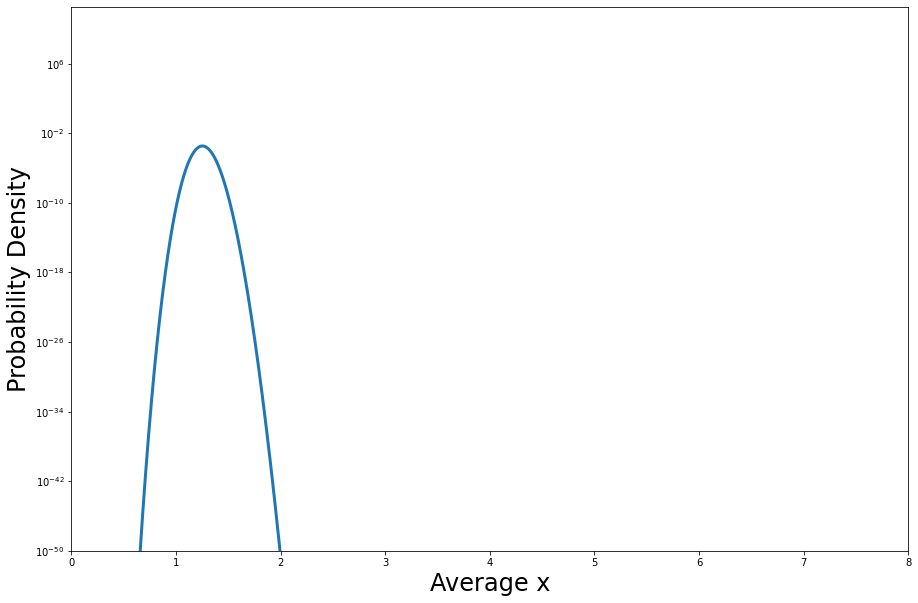

In [14]:
n = 200
plot_avg_rayleigh(x, rayleigh_pdf / 100, n, linewidth=3) # Had to scale the original pdf to plot
plt.xlabel("Average x", fontsize=24)
plt.ylabel("Probability Density", fontsize=24)
plt.yscale('log')
plt.xlim(0, 8)
plt.ylim(1e-50, None);

Because the y-axis was getting enormous even in the log scale, we had to scale the original distribution in order to see the average over 200 intervals. Though, now that we have seen it, we can see that after averaging over 200 intervals the distribution does appear to lose its Rayleigh "tail" and become approximately Gaussian.

##### Real World Application
The discovery of optical/infra-red counterparts of Neutron star mergers initially detected with gravity-waves is one of the great discoveries in the last few years, and has ushered in the age of "multi-messenger astrophysics." The science that can be done by matching a gravity-wave signal (directly measures the mass of the neutron stars and their distance) with the optical emisson (redshift, nuclear astrophysics of the resulting explosion) is staggering. Lots of science - from how the heaviest elements are formed to constraints on dark energy.

We're going to explore one of the analysis questions that comes up when looking for the optical counterparts (a new optical source) of a gravity wave signal. For this problem let's assume that we are using an optical telescope with a thermal noise background from the CCD (dark current, particularly an issue with older CCDs and/or infra-red CCDs). After flat-fielding, the background appears as a zero-mean Gaussian with constant width over the image.

##### "Real World Scenario" #1
Say we have an alert from LIGO that is also seen with the X-ray/ultra-violet satellite SWIFT. SWIFT gives us a very precise location, so we take an image of that part of the sky, but because of SWIFT's accuracy, we know which pixel in our image to look for a counterpart in.

From looking at all the other pixels in our image, we can measure the width of the background Gaussian distribution, X. Assuming we see a signal of strength Y,  we calculate the significance of our detection and test if we can claim a discovery (traditionally 5-sigma or more).
First we visualize the distribution of one pixel. We choose our X (width of background distribution) to be 2 brightness units. 

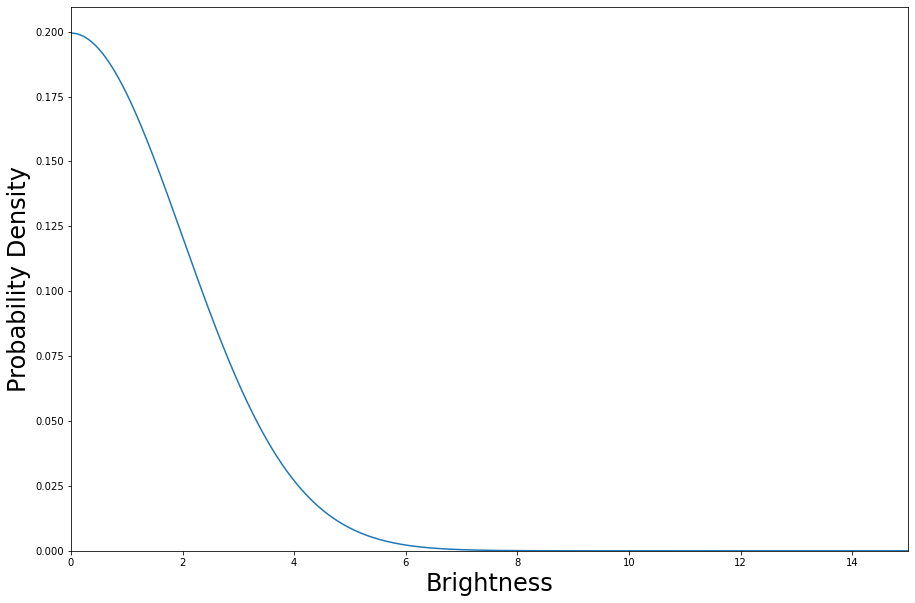

In [15]:
norm_dist = stats.norm(scale=2)

x = np.linspace(0, 15, 1000)
plt.xlabel("Brightness", fontsize=24)
plt.ylabel("Probability Density", fontsize=24)
plt.plot(x, norm_dist.pdf(x))
plt.xlim(0, 15)
plt.ylim(0, None);

We then test if we can claim a discovery if we assume a signal at a value of 12.4 on this one pixel. To answer this question, we integrate the PDF of the background noise distribution for 1 pixel from 12.4.

In [16]:
prob = norm_dist.sf(12.4)
prob

2.823158037043268e-10

This is a small probability, but converting to a sigma value:

In [17]:
stats.norm.ppf(1 - prob)
print(f'The sigma value associated with getting a signal of value 12 is {stats.norm.ppf(1 - prob):.2f},\nwhich means we can claim a discovery.')

The sigma value associated with getting a signal of value 12 is 6.20,
which means we can claim a discovery.


##### "Real World Scenario" #2
We now have an alert from LIGO, but no associated detection from SWIFT. This could be because it is a black hole merger, a black hole-neutron star merger (neither seem to emit X-rays or UV light), or it could because SWIFT was indisposed at the time (wrong side of the earth in its orbit). Whatever the cause, we know what region of the sky to look in, but not which pixel.
 
##### If we have to look for a signal in 10,000 pixels, what is the probability distribution of our background?
We can accomplish this by multiplying our distribution for one pixel by 10k, as our process is for every pixel we do not find a signal-like brightness on, we look at the next one.

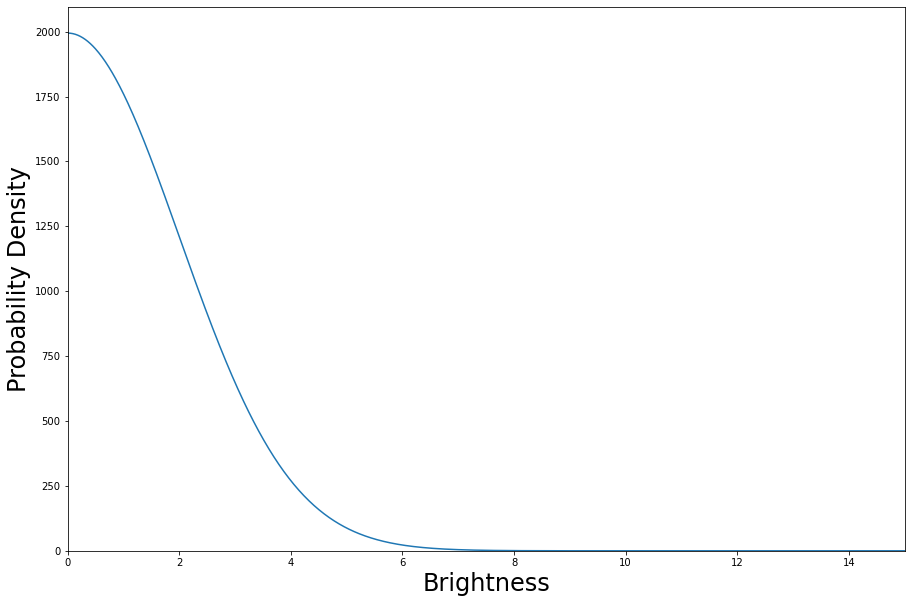

In [18]:
# Expanding the background to combine 10,000 pixels (note difference in y-axis):

x = np.linspace(0, 15, 1000)
plt.xlabel("Brightness", fontsize=24)
plt.ylabel("Probability Density", fontsize=24)
plt.plot(x, 10_000 * norm_dist.pdf(x))
plt.xlim(0, 15)
plt.ylim(0, None);

Taking our brightest candidate signal from the region (assuming it has the same signal of 12.4 as in our first example), we calculate the significance of our detection.

We see that the y-axis has been dramatically increased (by an order of 10,000), thus we shall recalculate the sigma value of our candidate signal again to see if we should still claim a discovery.

In [19]:
prob = 10_000 * norm_dist.sf(12.4)
print(prob)

2.823158037043268e-06


In [20]:
stats.norm.ppf(1 - prob)
print(f'The sigma value associated with getting a signal of value 12 is now {stats.norm.ppf(1 - prob):.2f},\nwhich means we cannot claim a discovery.')

The sigma value associated with getting a signal of value 12 is now 4.54,
which means we cannot claim a discovery.


##### Trials Factor
The statistical issue we were exploring in the previous problem is called a trials factor (sometimes known as a look-elsewhere effect). This is an important effect, as if you were to search through a million locations, you would expect to see ~1 one in a million event. However, it is also often over estimated how big an impact this makes on the sensitivity of a search. To explore this, let us invert the problem we just discussed.

We will calculate the signal required for a 5-sigma detection in "Real World Scenario" #1
To do this we should use the survival function in scipy.

In [21]:
prob = stats.norm.sf(5)
threshold1 = norm_dist.ppf(1 - prob)
print(f'A 5 sigma detection would require a signal threshold of {threshold1:.2f}.')

A 5 sigma detection would require a signal threshold of 10.00.


Now we will calculate the signal required for a 5-sigma detection in "Real World Scenario" #2 the same way. 

In [22]:
new_prob = prob / 10_000
threshold2 = norm_dist.ppf(1 - new_prob)
print(f'A 5 sigma detection would require a signal threshold of {threshold2:.2f}, or {(threshold2/threshold1 - 1)*100:.2f}% brighter with 10,000 pixels.')

A 5 sigma detection would require a signal threshold of 13.10, or 31.01% brighter with 10,000 pixels.


In [23]:
# Taking the ratio of both signal thresholds

norm_dist.sf(threshold2) / norm_dist.sf(threshold1)

0.00010000008423938025

This ratio is expected, a 1 in 10,000 chance. This seems like a low sensitivity penalty, but it is made up for by the large decrease in probability of seeing a signal at or above the slightly increased threshold.

#### If we change the trial factor significantly (orders of magnitude), how large is the effect on our 5-sigma sensitivity threshold?
Let's arbitrarily make the new trial factor 10 million rather than 10 thousand.

In [24]:
n = 10e6 # Let n be the new trials factor
new_prob = prob / n
threshold3 = norm_dist.ppf(1 - new_prob)
print(f'Therefore, with 10 million trials, we would need a signal about {(threshold3/threshold1 - 1)*100:.2f}% brighter than our original signal in order to consider it a discovery.')

Therefore, with 10 million trials, we would need a signal about 50.28% brighter than our original signal in order to consider it a discovery.


We can plot this relationship to see what kind of behavior it has:

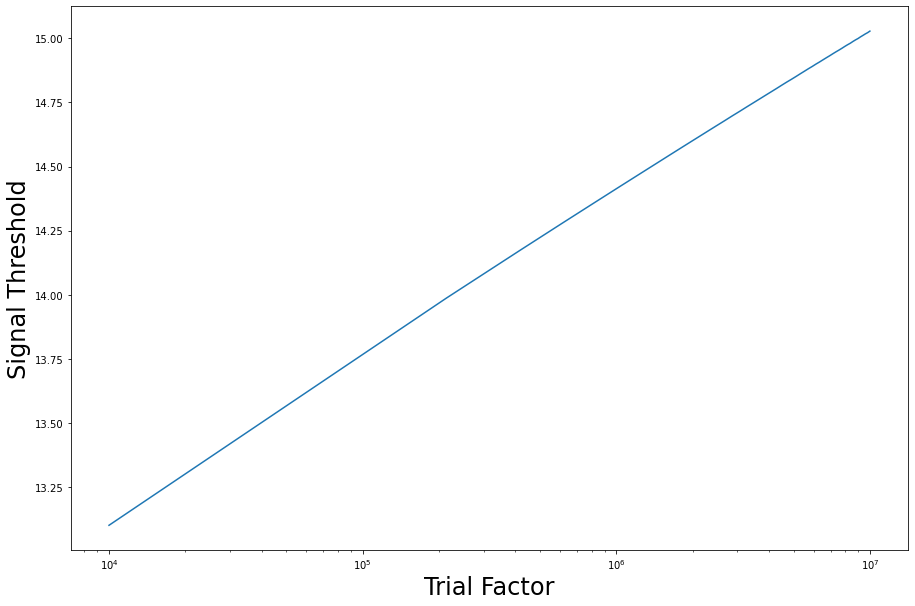

In [25]:
n = np.linspace(1e4, 1e7)
new_probs = prob / n
thresholds = norm_dist.ppf(1 - new_probs)
plt.semilogx(n, thresholds)
plt.xlabel('Trial Factor', fontsize=24)
plt.ylabel('Signal Threshold', fontsize=24);

Thus, we see that the threshold increases logarithmically with the trial factor (note semi-log axis scale).